# Fraud Detection Analysis

## Project Overview
This notebook presents a comprehensive fraud detection analysis using machine learning techniques. The project is divided into two main parts:

1. **Part 1: Anomaly Detection** - Identifying temporal anomalies in fraud patterns and investigating root causes
2. **Part 2: Fraud Detection Models** - Building and optimizing ML models with and without FraudKiller features to maximize business profitability

## Objectives
- Detect anomalies in fraud rates over time using time-series analysis
- Investigate potential root causes of fraud spikes
- Develop and compare multiple machine learning models for fraud detection
- Optimize decision thresholds to maximize business profit while maintaining effective fraud detection
- Evaluate the impact of FraudKiller features on model performance

## Methodology
- **Data Preprocessing**: Handling missing values using KNN imputation, feature engineering, and data validation
- **Anomaly Detection**: Isolation Forest for identifying unusual patterns in fraud rates
- **Model Development**: Logistic Regression, Random Forest, and XGBoost classifiers
- **Hyperparameter Tuning**: Grid Search CV for optimal model parameters
- **Business Optimization**: Threshold optimization using profit maximization functions

# Part 1: Anomaly Detection and Root Cause Analysis

In this section, we will:
- Load and explore the fraud detection dataset
- Perform comprehensive data cleaning and preprocessing
- Conduct time-series analysis to identify anomalies in fraud patterns
- Investigate potential root causes of fraud spikes during anomalous periods

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from scipy.optimize import minimize

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Dataset Overview
The dataset contains information about applications, including features such as:
- Application ID
- Product type
- Industry
- Location (city and state)
- Application date
- Fraud-related indicators such as fraud scores and credit scores

The dataset will be loaded and explored in the following steps.

## Loading the Dataset
The dataset is imported using pandas.

In [ ]:
# Load the fraud detection dataset
fraud = pd.read_excel('data/raw/FraudCaseStudy.xlsx')

## Exploring the Data
Initial data exploration includes examining the dataset's structure.

In [3]:
fraud.head()

,application_id,product,industry,city,state,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date
0,2454736213109889,Desktop,Retail Trade,CHICAGO HEIGHTS,IL,2019-09-07,APPROVED,0,5.50,40.050,2019-09-11
1,2406652813647864,Desktop,Services,WINTER HAVEN,FL,2019-09-30,APPROVED,0,9.38,4.800,2019-09-30
2,2491009212283403,Desktop,Services,MADISON,WI,2019-08-12,DECLINED,0,9.25,78.500,NaT
3,2349701212241921,Desktop,Retail Trade,FAYETTEVILLE,AR,2019-09-26,APPROVED,0,8.53,4.925,NaT
4,2380050314918284,Desktop,Services,CLEVELAND,OH,2019-08-24,APPROVED,0,8.25,5.200,2019-09-09


In [4]:
fraud.shape

(233839, 11)

## Data Cleaning & EDA
In this section, we will handle missing values, remove duplicates, and preprocess columns to ensure the dataset is ready for analysis.

Here's an overview of number of data missing is each column:

In [5]:
fraud.isna().sum()

application_id                 0
product                        0
industry                       0
city                           0
state                          0
application_date               0
final_decision                 0
is_fraud                       0
credit_score               14071
fraud_score                 5447
first_transaction_date    129095
dtype: int64

Now let's check column one by one. For `application_id`, I am checking whether each id is unique avoiding duplicate rows.

In [6]:
# check for application_id
print(len(fraud['application_id'].unique()))
fraud['application_id'].unique()

233839


array([2454736213109889, 2406652813647864, 2491009212283403, ...,
       2364903814884193, 2380907513969725, 2361727112385166])

`application_id` looks good and now we move to the `product` column:

In [ ]:
# Check for product
fraud['product'].unique()

array(['Desktop', 'Other', 'Mobile App', 'Online', 'Point of Sales',
       'Desktop (Mac)', 'Self-employee'], dtype=object)

Seems to be fine. What about `industry` column?

In [8]:
# check for industry
fraud['industry'].unique()

array(['Retail Trade', 'Services', 'Agriculture, Forestry, And Fishing',
       'Wholesale Trade', 'Construction',
       'Transportation, Communications, Electric, Gas, And Sanitary Services',
       'Manufacturing', 'Finance, Insurance, And Real Estate',
       'Public Administration'], dtype=object)

In [9]:
fraud.columns

Index(['application_id', 'product', 'industry', 'city', 'state',
       'application_date', 'final_decision', 'is_fraud', 'credit_score',
       'fraud_score', 'first_transaction_date'],
      dtype='object')

 Next to check is `city` and `state`

In [10]:
pd.Series(fraud['city'].unique())

0        CHICAGO HEIGHTS
1           WINTER HAVEN
2                MADISON
3           FAYETTEVILLE
4              CLEVELAND
              ...       
11337                GEM
11338           WHITELAW
11339             MANGUM
11340            WANAQUE
11341         ARROWSMITH
Length: 11342, dtype: object

In [11]:
pd.Series(fraud['state'].unique())

0     IL
1     FL
2     WI
3     AR
4     OH
5     CA
6     MT
7     WA
8     MI
9     ND
10    CT
11    IN
12    ID
13    GA
14    TX
15    LA
16    AL
17    NM
18    VA
19    MD
20    AZ
21    MA
22    CO
23    OR
24    NC
25    TN
26    OK
27    SC
28    NY
29    KS
30    DC
31    SD
32    PA
33    MN
34    UT
35    MO
36    KY
37    MS
38    ME
39    NJ
40    NV
41    WY
42    WV
43    IA
44    NE
45    AK
46    NH
47    HI
48    PR
49    RI
50    VT
51    DE
52    VI
53    AS
54    GU
55    PW
56    MP
57    MH
dtype: object

Everything looks okay so far. What about `application_date`?

In [12]:
# check for application date
fraud['application_date'].unique()

array(['2019-09-07T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-08-12T00:00:00.000000000', '2019-09-26T00:00:00.000000000',
       '2019-08-24T00:00:00.000000000', '2019-05-21T00:00:00.000000000',
       '2019-09-25T00:00:00.000000000', '2019-09-27T00:00:00.000000000',
       '2019-09-29T00:00:00.000000000', '2019-05-22T00:00:00.000000000',
       '2019-06-20T00:00:00.000000000', '2019-05-23T00:00:00.000000000',
       '2019-09-16T00:00:00.000000000', '2019-08-28T00:00:00.000000000',
       '2019-07-17T00:00:00.000000000', '2019-05-08T00:00:00.000000000',
       '2019-09-19T00:00:00.000000000', '2019-06-03T00:00:00.000000000',
       '2019-05-17T00:00:00.000000000', '2019-06-24T00:00:00.000000000',
       '2019-08-18T00:00:00.000000000', '2019-05-12T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-06-14T00:00:00.000000000',
       '2019-06-13T00:00:00.000000000', '2019-07-24T00:00:00.000000000',
       '2019-09-06T00:00:00.000000000', '2019-05-14

Looks good. Moving onto `final_decision`:

In [13]:
fraud['final_decision'].unique()

array(['APPROVED', 'DECLINED', 'PENDING', 'CANCELLED'], dtype=object)

The `is_fraud` column:

In [14]:
# check for is_fraud
fraud['is_fraud'].unique()

array([0, 1])

From now on, we are going to deal with some `np.nan` values.

In [ ]:
# Libraries already imported at the beginning

In [16]:
fraud['credit_score'].dropna()

0         5.50
1         9.38
2         9.25
3         8.53
4         8.25
          ... 
233833    0.02
233834    6.94
233835    7.92
233836    8.29
233838    6.07
Name: credit_score, Length: 219768, dtype: float64

Let's visualize the distribution of `credit_score` to see how to better do imputation:

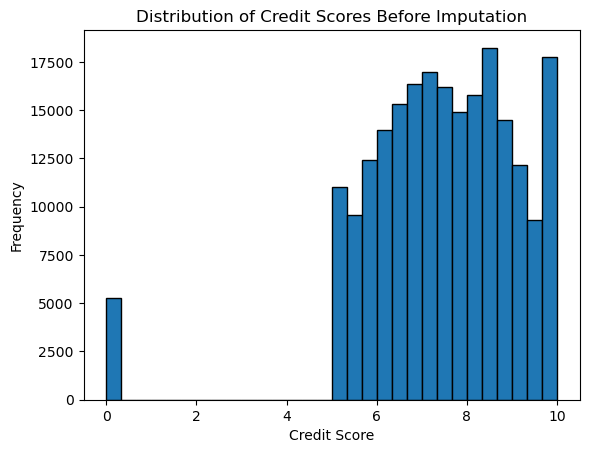

In [17]:
# check for credit_score
credit_scores = fraud['credit_score'].dropna()
zoom_range = (0, 10)
plt.hist(credit_scores, bins=30, range=zoom_range, edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Scores Before Imputation')

plt.show()

**Question**: Would mean imputation be a good approach for handling missing credit scores?

In [18]:
# mean imputation?
mean = fraud['credit_score'].dropna().mean()
mean

7.398933602708309

The mean value doesn't seem representative of the underlying distribution. Let's explore group-based imputation: if a missing value comes from the `is_fraud == 1` group, we could replace it with that group's mean `credit_score`.

In [19]:
is_fraud_mean = fraud[fraud['is_fraud'] == 1]['credit_score'].dropna().mean()
print(is_fraud_mean)
not_fraud_mean = fraud[fraud['is_fraud'] == 0]['credit_score'].dropna().mean()
print(not_fraud_mean)

7.922807523655666
7.377427925836802


The mean values still don't seem representative of the underlying distribution. We'll use **KNN (K-Nearest Neighbors) imputation** to leverage relationships between features for more accurate imputation.

In [ ]:
# Libraries already imported at the beginning

In [21]:
# let's try KNN
fraud_for_imputation = fraud.copy().drop(columns = ['application_id', 'city', 'state'])
fraud_for_imputation['is_fraud'] = fraud_for_imputation['is_fraud'].apply(lambda x: True if x == 1 else False)

In [22]:
numerical_cols = fraud_for_imputation.select_dtypes(include=['float64', 'int64']).columns.drop('credit_score')
categorical_cols = fraud_for_imputation.select_dtypes(include=['object', 'boolean']).columns

In [23]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray() if hasattr(X, 'toarray') else X
credit_imputer = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', DenseTransformer()),
    ('imputer', KNNImputer(n_neighbors=5))
])

In [25]:
pipeline_preprocess = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', DenseTransformer())
])
preprocessed_data = pipeline_preprocess.fit_transform(fraud_for_imputation)

In [26]:
encoded_cat_cols = pipeline_preprocess.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_columns = numerical_cols.tolist() + encoded_cat_cols.tolist()
preprocessed_df = pd.DataFrame(preprocessed_data, columns=all_columns)
preprocessed_df['credit_score'] = fraud['credit_score']
preprocessed_df.head()

,fraud_score,product_Desktop,product_Desktop (Mac),product_Mobile App,product_Online,product_Other,product_Point of Sales,product_Self-employee,"industry_Agriculture, Forestry, And Fishing",industry_Construction,...,industry_Services,"industry_Transportation, Communications, Electric, Gas, And Sanitary Services",industry_Wholesale Trade,final_decision_APPROVED,final_decision_CANCELLED,final_decision_DECLINED,final_decision_PENDING,is_fraud_False,is_fraud_True,credit_score
0,-0.402814,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.50
1,-0.490267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.38
2,-0.307423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,9.25
3,-0.489957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8.53
4,-0.489274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8.25


In [27]:
chunk_size = 5000
chunks = [preprocessed_df.iloc[i:i + chunk_size] for i in range(0, preprocessed_df.shape[0], chunk_size)]
def impute_chunk(chunk):
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_chunk = knn_imputer.fit_transform(chunk)
    return pd.DataFrame(imputed_chunk, columns=chunk.columns)
imputed_chunks = [impute_chunk(chunk) for chunk in chunks]
imputed_df = pd.concat(imputed_chunks, axis=0)

In [28]:
fraud['credit_score'] = imputed_df['credit_score'].reset_index()['credit_score']

In [29]:
fraud.isna().sum()

application_id                 0
product                        0
industry                       0
city                           0
state                          0
application_date               0
final_decision                 0
is_fraud                       0
credit_score                   0
fraud_score                 5447
first_transaction_date    129095
dtype: int64

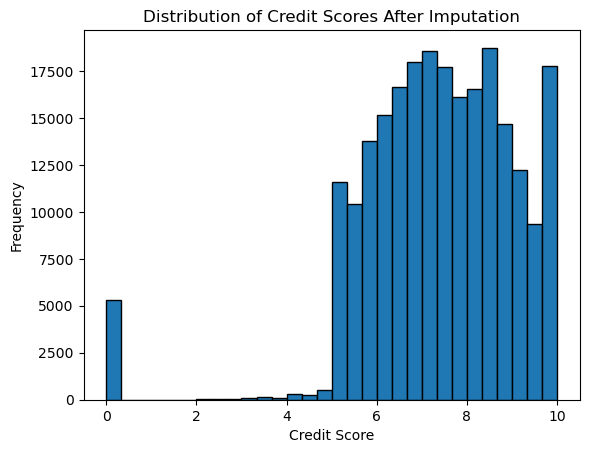

In [30]:
credit_scores = fraud['credit_score'].dropna()
zoom_range = (0, 10)
plt.hist(credit_scores, bins=30, range=zoom_range, edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Scores After Imputation')

plt.show()

Now there is no missing values in `credit_score` and we would do the same thing to the `fraud_score` column.

In [31]:
# same logic for fraud score
numerical_cols = fraud_for_imputation.select_dtypes(include=['float64', 'int64']).columns.drop('fraud_score')
categorical_cols = fraud_for_imputation.select_dtypes(include=['object', 'boolean']).columns

In [32]:
preprocessed_data = pipeline_preprocess.fit_transform(fraud_for_imputation)
encoded_cat_cols = pipeline_preprocess.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_columns = numerical_cols.tolist() + encoded_cat_cols.tolist()
preprocessed_df = pd.DataFrame(preprocessed_data, columns=all_columns)
preprocessed_df['fraud_score'] = fraud['fraud_score']
preprocessed_df.head()

,credit_score,product_Desktop,product_Desktop (Mac),product_Mobile App,product_Online,product_Other,product_Point of Sales,product_Self-employee,"industry_Agriculture, Forestry, And Fishing",industry_Construction,...,industry_Services,"industry_Transportation, Communications, Electric, Gas, And Sanitary Services",industry_Wholesale Trade,final_decision_APPROVED,final_decision_CANCELLED,final_decision_DECLINED,final_decision_PENDING,is_fraud_False,is_fraud_True,fraud_score
0,-0.402814,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,40.050
1,-0.490267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.800
2,-0.307423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,78.500
3,-0.489957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.925
4,-0.489274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.200


In [33]:
chunk_size = 1000
chunks = [preprocessed_df.iloc[i:i + chunk_size] for i in range(0, preprocessed_df.shape[0], chunk_size)]
def impute_chunk(chunk):
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_chunk = knn_imputer.fit_transform(chunk)
    return pd.DataFrame(imputed_chunk, columns=chunk.columns)
imputed_chunks = [impute_chunk(chunk) for chunk in chunks]
imputed_df = pd.concat(imputed_chunks, axis=0)

In [34]:
imputed_df.head()

,credit_score,product_Desktop,product_Desktop (Mac),product_Mobile App,product_Online,product_Other,product_Point of Sales,product_Self-employee,"industry_Agriculture, Forestry, And Fishing",industry_Construction,...,industry_Services,"industry_Transportation, Communications, Electric, Gas, And Sanitary Services",industry_Wholesale Trade,final_decision_APPROVED,final_decision_CANCELLED,final_decision_DECLINED,final_decision_PENDING,is_fraud_False,is_fraud_True,fraud_score
0,-0.402814,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,40.050
1,-0.490267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.800
2,-0.307423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,78.500
3,-0.489957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.925
4,-0.489274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.200


In [35]:
fraud['fraud_score'] = imputed_df['fraud_score'].reset_index()['fraud_score']

In [36]:
fraud.isna().sum()

application_id                 0
product                        0
industry                       0
city                           0
state                          0
application_date               0
final_decision                 0
is_fraud                       0
credit_score                   0
fraud_score                    0
first_transaction_date    129095
dtype: int64

## Save Cleaned Dataset

After completing all data cleaning steps (missing value imputation, data quality fixes), we save the cleaned dataset for future use.


In [ ]:
# Save cleaned Part 1 dataset
fraud.to_excel('data/cleaned/fraud_cleaned.xlsx', index=False)
print(f"Cleaned dataset saved to data/cleaned/fraud_cleaned.xlsx")
print(f"Dataset shape: {fraud.shape}")
print(f"Missing values: {fraud.isna().sum().sum()}")


Now let's check for anomalies in `first_transaction_date`:

In [37]:
# check for anomalies in first_transaction_date
(fraud['application_date'] > fraud['first_transaction_date']).sum()

1043

**Data Quality Issue Detected**: Some records have `first_transaction_date` earlier than `application_date`, which is logically inconsistent. We need to investigate and correct these anomalies.

In [38]:
fraud[fraud['application_date'] > fraud['first_transaction_date']]

,application_id,product,industry,city,state,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date
581,2343372412010125,Desktop,Construction,BEDFORD,TX,2019-09-20,APPROVED,0,6.95,43.875,2017-11-27
8366,2490956713073811,Desktop,Services,PORTLAND,OR,2019-07-03,APPROVED,0,6.98,45.600,2019-04-04
11586,2210616413748047,Desktop,Services,SANTA ANA,CA,2019-04-11,APPROVED,0,6.46,193.300,2018-07-22
23742,2339151314996981,Mobile App,Construction,OKLAHOMA CITY,OK,2019-09-28,APPROVED,1,5.43,732.200,2019-09-13
23808,2404847413389706,Mobile App,Construction,SACRAMENTO,CA,2019-08-22,APPROVED,0,7.50,65.800,2019-06-13
...,...,...,...,...,...,...,...,...,...,...,...
198649,2326695212158758,Online,Services,FORT WORTH,TX,2019-06-11,APPROVED,0,5.95,39.800,2018-10-24
198696,2382544113187986,Online,Services,HUNTLEY,IL,2019-04-04,DECLINED,0,6.01,551.905,2017-03-28
198829,2312111214851202,Online,Services,MIAMI,FL,2019-09-16,APPROVED,0,7.13,36.675,2019-02-21
198832,2427529513926029,Online,Services,TOLEDO,OH,2019-04-04,APPROVED,0,5.01,75.950,2019-04-01


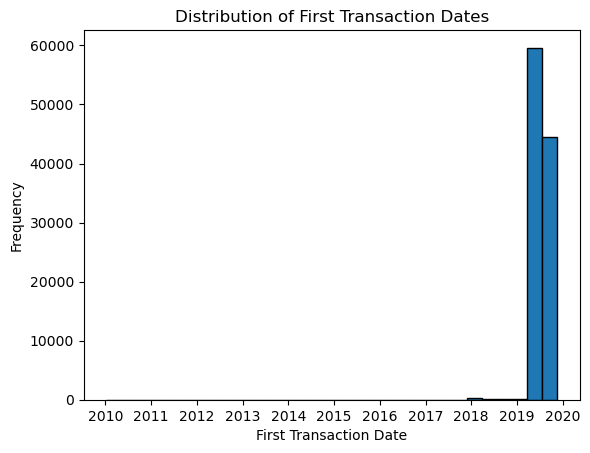

In [39]:
first_trans = fraud['first_transaction_date'].dropna()
plt.hist(first_trans, bins=30, edgecolor='black')
plt.xlabel('First Transaction Date')
plt.ylabel('Frequency')
plt.title('Distribution of First Transaction Dates')

plt.show()

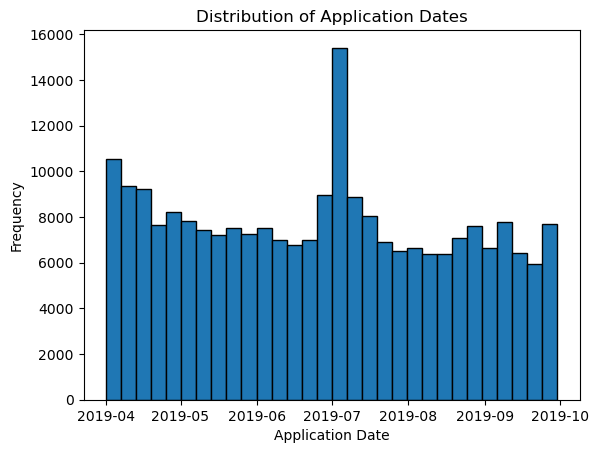

In [40]:
application_date = fraud['application_date'].dropna()
plt.hist(application_date, bins=30, edgecolor='black')
plt.xlabel('Application Date')
plt.ylabel('Frequency')
plt.title('Distribution of Application Dates')

plt.show()

From the two distributions above, we see that there is only a few records in `first_transaction_date` that are prior to 2019 and most of the application dates are around 2019, so I believe there is an error in recording those first transaction dates. I decided to replace these anomalies with their application date.

In [41]:
# might be a mistake when recording them, replace them with application date
def replace(first_transaction_date):
    application = fraud['application_date'].copy()
    copy = first_transaction_date.copy()
    for i in range(len(first_transaction_date)):
        if first_transaction_date.iloc[i] < application.iloc[i]:
            copy.iloc[i] = application.iloc[i]
    return copy
new_trans_date = replace(fraud['first_transaction_date'])
new_trans_date

0        2019-09-11
1        2019-09-30
2               NaT
3               NaT
4        2019-09-09
            ...    
233834          NaT
233835          NaT
233836   2019-07-18
233837          NaT
233838          NaT
Name: first_transaction_date, Length: 233839, dtype: datetime64[ns]

In [42]:
fraud.head()

,application_id,product,industry,city,state,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date
0,2454736213109889,Desktop,Retail Trade,CHICAGO HEIGHTS,IL,2019-09-07,APPROVED,0,5.50,40.050,2019-09-11
1,2406652813647864,Desktop,Services,WINTER HAVEN,FL,2019-09-30,APPROVED,0,9.38,4.800,2019-09-30
2,2491009212283403,Desktop,Services,MADISON,WI,2019-08-12,DECLINED,0,9.25,78.500,NaT
3,2349701212241921,Desktop,Retail Trade,FAYETTEVILLE,AR,2019-09-26,APPROVED,0,8.53,4.925,NaT
4,2380050314918284,Desktop,Services,CLEVELAND,OH,2019-08-24,APPROVED,0,8.25,5.200,2019-09-09


In [43]:
fraud[fraud['first_transaction_date'].isna()]

,application_id,product,industry,city,state,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date
2,2491009212283403,Desktop,Services,MADISON,WI,2019-08-12,DECLINED,0,9.250,78.500,NaT
3,2349701212241921,Desktop,Retail Trade,FAYETTEVILLE,AR,2019-09-26,APPROVED,0,8.530,4.925,NaT
5,2442615514058161,Desktop,Retail Trade,EL MONTE,CA,2019-05-21,APPROVED,0,8.700,27.775,NaT
7,2395897013448723,Desktop,Services,ARLINGTON,WA,2019-09-27,APPROVED,0,9.480,20.325,NaT
8,2451914312163917,Desktop,Services,OLIVET,MI,2019-09-29,APPROVED,0,6.160,49.350,NaT
...,...,...,...,...,...,...,...,...,...,...,...
233833,2354703713637502,Self-employee,Services,OKLAHOMA CITY,OK,2019-08-09,DECLINED,0,0.020,844.850,NaT
233834,2447915212861646,Self-employee,Services,SILVER SPRING,MD,2019-07-02,APPROVED,0,6.940,4.975,NaT
233835,2328997514409225,Self-employee,Services,CONCORD,NC,2019-09-17,APPROVED,0,7.920,34.150,NaT
233837,2380907513969725,Self-employee,"Transportation, Communications, Electric, Gas,...",DURANGO,CO,2019-07-12,DECLINED,0,5.886,841.915,NaT


In [44]:
fraud.isna().sum()

application_id                 0
product                        0
industry                       0
city                           0
state                          0
application_date               0
final_decision                 0
is_fraud                       0
credit_score                   0
fraud_score                    0
first_transaction_date    129095
dtype: int64

In [45]:
type(fraud['first_transaction_date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
reference_date = pd.Timestamp('1970-01-01')
fraud['first_transaction_date_numeric'] = (fraud['first_transaction_date'] - reference_date).dt.days

In [47]:
fraud_for_imputation['first_transaction_date_numeric'] = fraud['first_transaction_date_numeric']

In [48]:
fraud_for_imputation['first_transaction_date']

0        2019-09-11
1        2019-09-30
2               NaT
3               NaT
4        2019-09-09
            ...    
233834          NaT
233835          NaT
233836   2019-07-18
233837          NaT
233838          NaT
Name: first_transaction_date, Length: 233839, dtype: datetime64[ns]

In [49]:
fraud_for_imputation = fraud_for_imputation.drop(columns = ['first_transaction_date'])

In [50]:
fraud_for_imputation.head()

,product,industry,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date_numeric
0,Desktop,Retail Trade,2019-09-07,APPROVED,False,5.50,40.050,18150.0
1,Desktop,Services,2019-09-30,APPROVED,False,9.38,4.800,18169.0
2,Desktop,Services,2019-08-12,DECLINED,False,9.25,78.500,NaN
3,Desktop,Retail Trade,2019-09-26,APPROVED,False,8.53,4.925,NaN
4,Desktop,Services,2019-08-24,APPROVED,False,8.25,5.200,18148.0


## Time-Series Anomaly Detection

This section focuses on detecting anomalies in the time-series data:
- Aggregate daily fraud metrics (fraud rate, approval rate, application volume)
- Visualize temporal patterns to identify unusual periods
- Use statistical analysis to pinpoint anomaly periods
- Investigate root causes by comparing distributions during normal vs. anomalous periods

### Approach:
1. **Daily Aggregation**: Group data by `application_date` to compute daily metrics
2. **Visualization**: Plot fraud rates, approval rates, and application volumes over time
3. **Anomaly Identification**: Identify periods with unusual patterns across multiple metrics
4. **Root Cause Analysis**: Compare feature distributions between normal and anomalous periods

In [51]:
fraud_for_imputation.columns

Index(['product', 'industry', 'application_date', 'final_decision', 'is_fraud',
       'credit_score', 'fraud_score', 'first_transaction_date_numeric'],
      dtype='object')

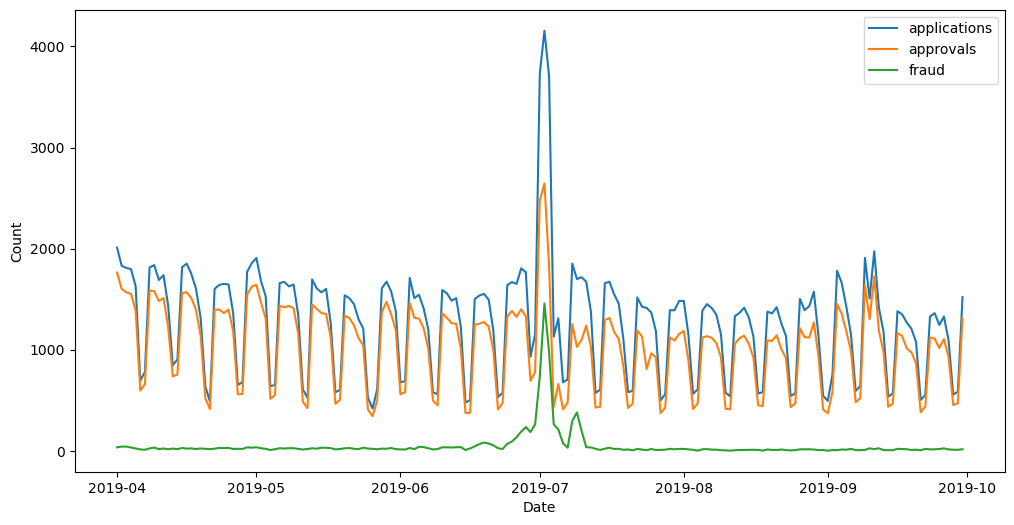

In [52]:
fraud_for_imputation['application_date'] = pd.to_datetime(fraud_for_imputation['application_date'])
fraud_for_imputation['first_transaction_date'] = pd.to_datetime(fraud['first_transaction_date'])
fraud_for_imputation['application_id'] = fraud['application_id']
fraud_for_imputation['application_date'] = fraud_for_imputation['application_date'].dt.date
daily_data = fraud_for_imputation.groupby('application_date').agg({
    'application_id': 'count',
    'final_decision': lambda x: (x == 'APPROVED').sum(),
    'is_fraud': 'sum'
}).reset_index()

daily_data.columns = ['date', 'applications', 'approvals', 'fraud']

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(daily_data['date'], daily_data['applications'], label='applications')
plt.plot(daily_data['date'], daily_data['approvals'], label='approvals')
plt.plot(daily_data['date'], daily_data['fraud'], label='fraud')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [53]:
daily_data.head()

,date,applications,approvals,fraud
0,2019-04-01,2010,1763,34
1,2019-04-02,1829,1602,42
2,2019-04-03,1809,1567,42
3,2019-04-04,1797,1553,33
4,2019-04-05,1630,1390,25


In [54]:
daily_data['fraud_rate'] = daily_data['fraud'] / daily_data['applications']
daily_data['approval_rate'] = daily_data['approvals'] / daily_data['applications']
daily_data['app_rate'] = daily_data['applications'] / daily_data['applications'].sum()

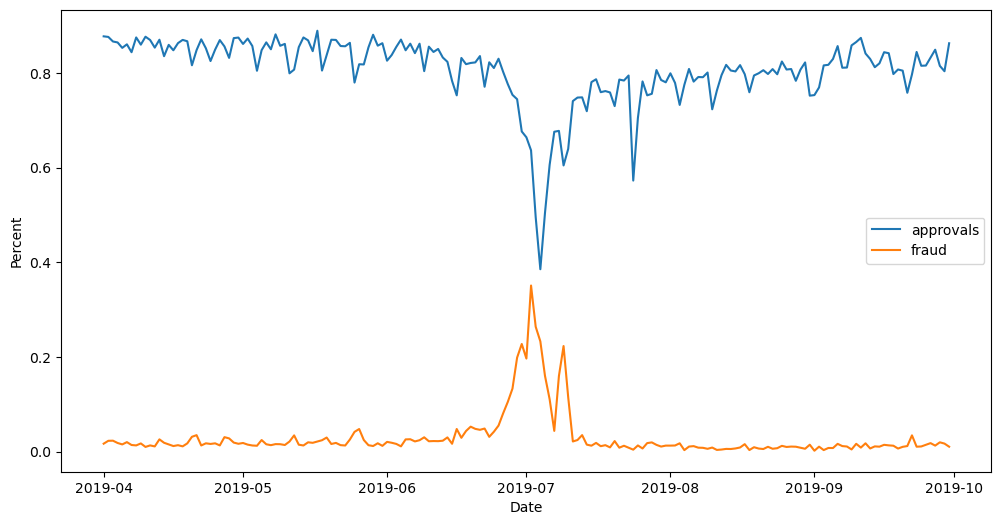

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data['date'], daily_data['approval_rate'], label='approvals')
plt.plot(daily_data['date'], daily_data['fraud_rate'], label='fraud')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.show()

In [56]:
daily_data['avg_fraud_score'] = fraud.groupby('application_date')['fraud_score'].mean().reset_index()['fraud_score']

In [57]:
daily_data['avg_credit_score'] = fraud.groupby('application_date')['credit_score'].mean().reset_index()['credit_score']

In [58]:
daily_data.head()

,date,applications,approvals,fraud,fraud_rate,approval_rate,app_rate,avg_fraud_score,avg_credit_score
0,2019-04-01,2010,1763,34,0.016915,0.877114,0.008596,142.444087,7.483347
1,2019-04-02,1829,1602,42,0.022963,0.875888,0.007822,154.957326,7.358189
2,2019-04-03,1809,1567,42,0.023217,0.866224,0.007736,172.173679,7.393797
3,2019-04-04,1797,1553,33,0.018364,0.864218,0.007685,156.236497,7.277228
4,2019-04-05,1630,1390,25,0.015337,0.852761,0.006971,153.687313,7.339334


In [ ]:
# Libraries already imported at the beginning

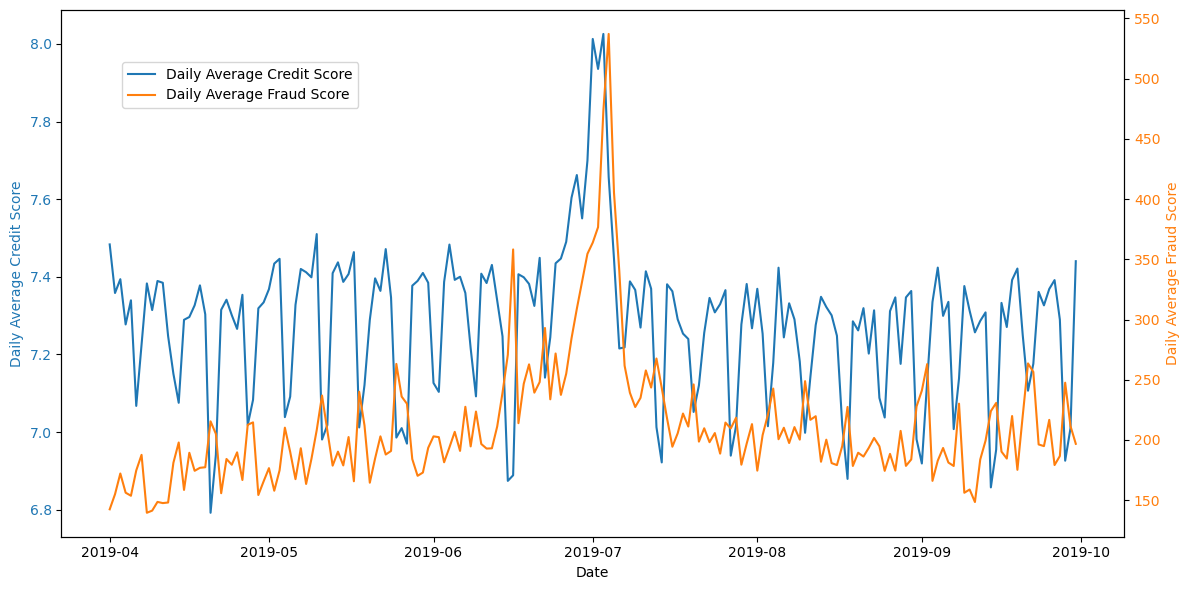

In [60]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Average Credit Score', color=color)
ax1.plot(daily_data['date'], daily_data['avg_credit_score'], color=color, label='Daily Average Credit Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Daily Average Fraud Score', color=color)
ax2.plot(daily_data['date'], daily_data['avg_fraud_score'], color=color, label='Daily Average Fraud Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


**Key Finding**: Anomalies occurred between **June 25 - July 4, 2019** across multiple metrics:
- Increased fraud rates
- Unusual patterns in credit and fraud scores
- Elevated application volumes

This suggests a coordinated fraud campaign during this period.

In [61]:
anomaly_period_start = '2019-06-25'
anomaly_period_end = '2019-07-04'

In [62]:
normal_period_data = fraud[((fraud['application_date'] < anomaly_period_start)) | ((fraud['application_date'] > anomaly_period_end))]
anomaly_period_data = fraud[(fraud['application_date'] >= anomaly_period_start) & (fraud['application_date'] <= anomaly_period_end)]

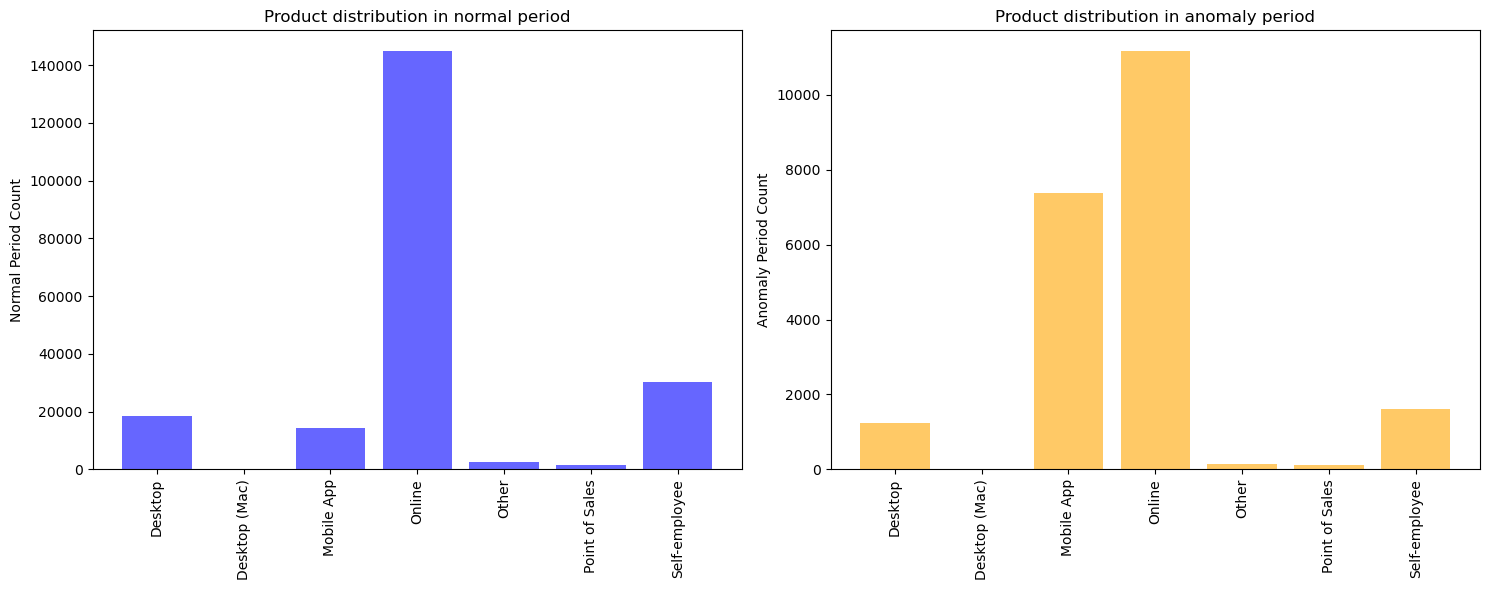

In [63]:
normal_period_distribution = normal_period_data['product'].value_counts().sort_index()
anomaly_period_distribution = anomaly_period_data['product'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

ax1.bar(normal_period_distribution.index, normal_period_distribution.values, color='blue', alpha=0.6)
ax1.set_title('Product distribution in normal period')
ax1.set_ylabel('Normal Period Count')
ax1.set_xticks(range(len(normal_period_distribution.index)))
ax1.set_xticklabels(normal_period_distribution.index, rotation=90)

ax2.bar(anomaly_period_distribution.index, anomaly_period_distribution.values, color='orange', alpha=0.6)
ax2.set_title('Product distribution in anomaly period')
ax2.set_ylabel('Anomaly Period Count')
ax2.set_xticks(range(len(anomaly_period_distribution.index)))
ax2.set_xticklabels(anomaly_period_distribution.index, rotation=90)

plt.tight_layout()
plt.show()

In [64]:
normal_period_state_counts = normal_period_data['state'].value_counts().sort_index()
anomaly_period_state_counts = anomaly_period_data['state'].value_counts().sort_index()

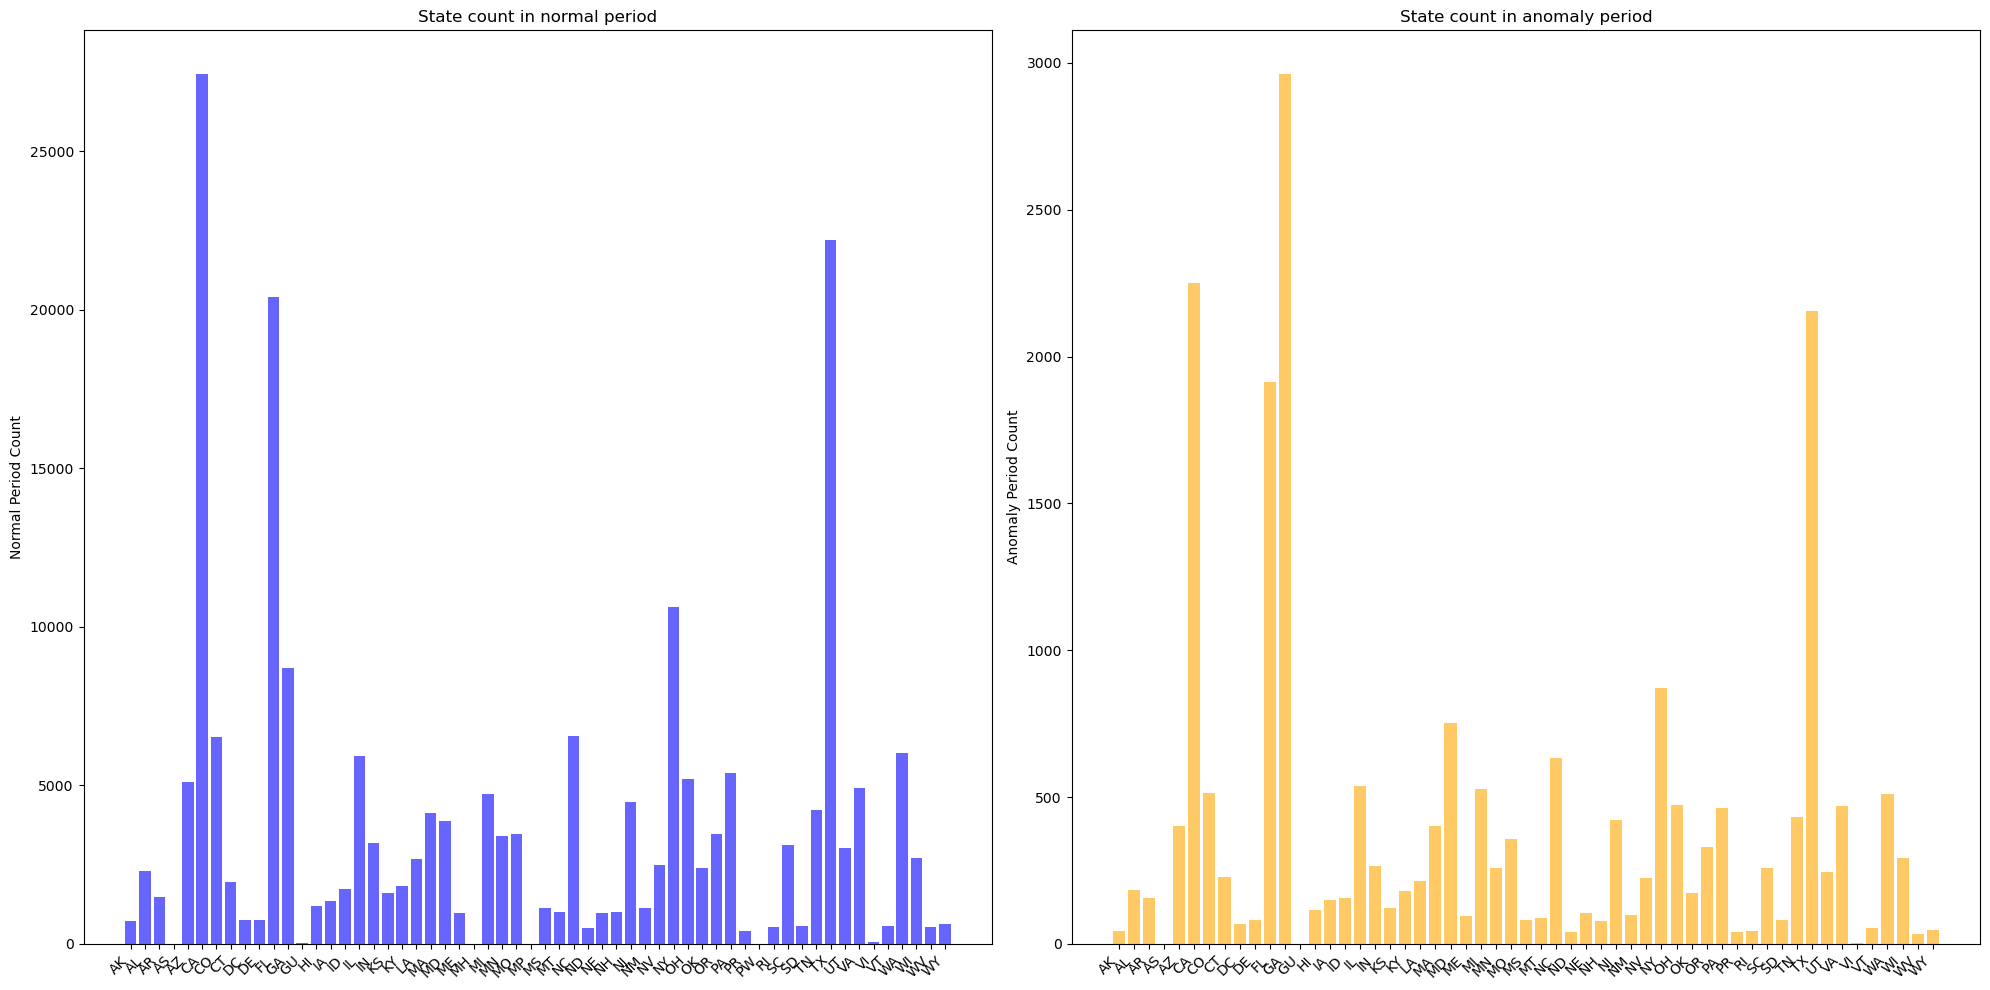

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

ax1.bar(normal_period_state_counts.index, normal_period_state_counts.values, color='blue', alpha=0.6)
ax1.set_title('State count in normal period')
ax1.set_ylabel('Normal Period Count')
ax1.set_xticks(range(len(normal_period_state_counts.index)))
ax1.set_xticklabels(normal_period_state_counts.index, rotation=45, ha='right')

ax2.bar(anomaly_period_state_counts.index, anomaly_period_state_counts.values, color='orange', alpha=0.6)
ax2.set_title('State count in anomaly period')
ax2.set_ylabel('Anomaly Period Count')
ax2.set_xticks(range(len(anomaly_period_state_counts.index)))
ax2.set_xticklabels(anomaly_period_state_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Root Cause Analysis

### Potential Root Causes:

1. **Targeted Fraud Campaign**: The spike in fraud rates suggests a coordinated fraud campaign where fraudsters exploited system vulnerabilities or targeted specific products/regions.

2. **Product Distribution Changes**: Comparing product distributions between normal and anomalous periods may reveal if certain products were targeted.

3. **Geographic Patterns**: State-level analysis can identify if the fraud was concentrated in specific regions.

4. **System Vulnerability**: The timing and intensity suggest potential exploitation of a system weakness or policy change.

## Isolation Forest for Anomaly Detection

**Why Isolation Forest?**
- **Unsupervised Learning**: Works without labeled data, identifying outliers based on data structure
- **Efficiency**: Fast training and prediction, suitable for real-time applications
- **High-Dimensional Robustness**: Handles multiple features simultaneously without assuming data distribution
- **Anomaly Scoring**: Provides clear anomaly scores (-1 for anomalies, 1 for normal) for threshold-based decision making
- **Fraud Detection Fit**: Fraudulent transactions are typically outliers compared to legitimate ones

We'll use Isolation Forest to detect anomalous days in our time-series data based on daily aggregated metrics.

In [ ]:
# Libraries already imported at the beginning

In [67]:
fraud_for_imputation.head()

,product,industry,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date_numeric,first_transaction_date,application_id
0,Desktop,Retail Trade,2019-09-07,APPROVED,False,5.50,40.050,18150.0,2019-09-11,2454736213109889
1,Desktop,Services,2019-09-30,APPROVED,False,9.38,4.800,18169.0,2019-09-30,2406652813647864
2,Desktop,Services,2019-08-12,DECLINED,False,9.25,78.500,NaN,NaT,2491009212283403
3,Desktop,Retail Trade,2019-09-26,APPROVED,False,8.53,4.925,NaN,NaT,2349701212241921
4,Desktop,Services,2019-08-24,APPROVED,False,8.25,5.200,18148.0,2019-09-09,2380050314918284


In [68]:
fraud_copy = fraud_for_imputation.copy()

In [69]:
fraud_copy['application_date'] = pd.to_datetime(fraud_copy['application_date'])
fraud_copy['is_fraud_numeric'] = fraud_copy['is_fraud'].astype(int)
fraud_copy['is_approved'] = fraud_copy['final_decision'].apply(lambda x: 1 if x == "APPROVED" else 0)
fraud_copy.head()

,product,industry,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date_numeric,first_transaction_date,application_id,is_fraud_numeric,is_approved
0,Desktop,Retail Trade,2019-09-07,APPROVED,False,5.50,40.050,18150.0,2019-09-11,2454736213109889,0,1
1,Desktop,Services,2019-09-30,APPROVED,False,9.38,4.800,18169.0,2019-09-30,2406652813647864,0,1
2,Desktop,Services,2019-08-12,DECLINED,False,9.25,78.500,NaN,NaT,2491009212283403,0,0
3,Desktop,Retail Trade,2019-09-26,APPROVED,False,8.53,4.925,NaN,NaT,2349701212241921,0,1
4,Desktop,Services,2019-08-24,APPROVED,False,8.25,5.200,18148.0,2019-09-09,2380050314918284,0,1


In [70]:
fraud_copy['application_num'] = fraud_copy['application_date'].apply(lambda x: 1)
fraud_copy.head()

,product,industry,application_date,final_decision,is_fraud,credit_score,fraud_score,first_transaction_date_numeric,first_transaction_date,application_id,is_fraud_numeric,is_approved,application_num
0,Desktop,Retail Trade,2019-09-07,APPROVED,False,5.50,40.050,18150.0,2019-09-11,2454736213109889,0,1,1
1,Desktop,Services,2019-09-30,APPROVED,False,9.38,4.800,18169.0,2019-09-30,2406652813647864,0,1,1
2,Desktop,Services,2019-08-12,DECLINED,False,9.25,78.500,NaN,NaT,2491009212283403,0,0,1
3,Desktop,Retail Trade,2019-09-26,APPROVED,False,8.53,4.925,NaN,NaT,2349701212241921,0,1,1
4,Desktop,Services,2019-08-24,APPROVED,False,8.25,5.200,18148.0,2019-09-09,2380050314918284,0,1,1


In [71]:
daily_data = fraud_copy.groupby('application_date').agg({
    'application_id': 'count',
    'final_decision': lambda x: (x == 'APPROVED').sum(),
    'is_fraud': 'mean'
}).reset_index()
daily_data.head()

,application_date,application_id,final_decision,is_fraud
0,2019-04-01,2010,1763,0.016915
1,2019-04-02,1829,1602,0.022963
2,2019-04-03,1809,1567,0.023217
3,2019-04-04,1797,1553,0.018364
4,2019-04-05,1630,1390,0.015337


/Users/yuhetian/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


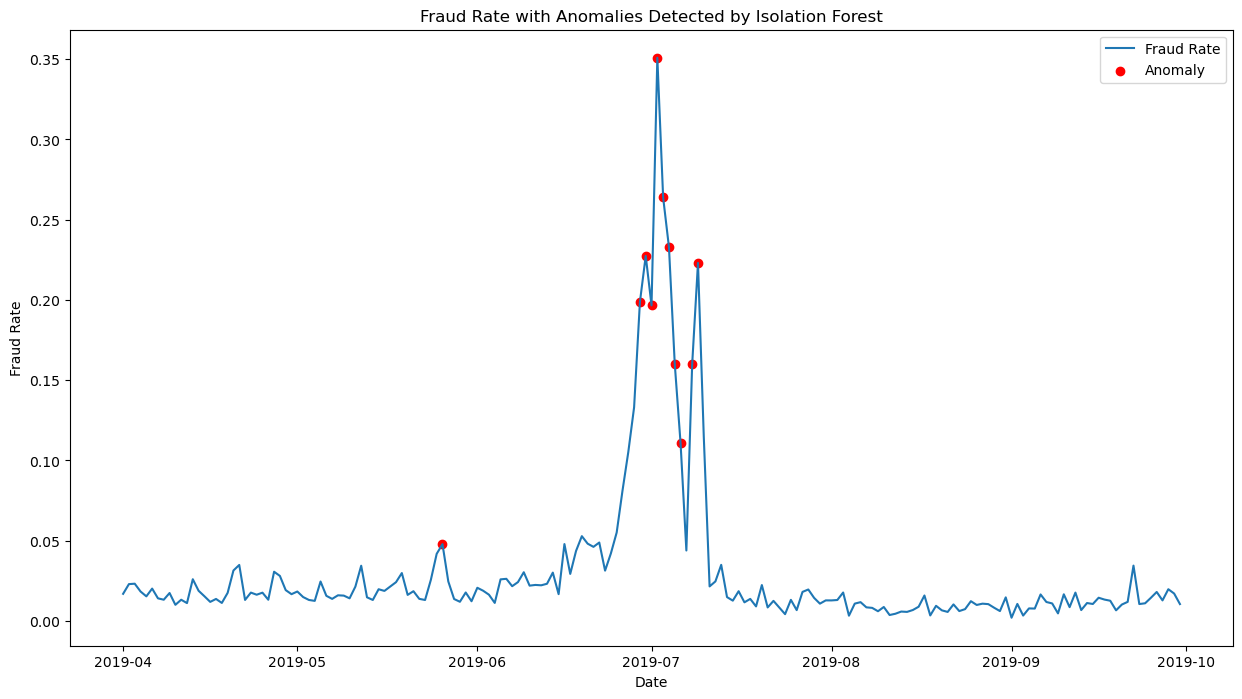

Number of anomalies detected: 11
   application_date  application_id  final_decision  is_fraud  anomaly_score  \
55       2019-05-26             418             342  0.047847             -1   
89       2019-06-29             931             693  0.198711             -1   
90       2019-06-30            1152             779  0.227431             -1   
91       2019-07-01            3728            2475  0.196620             -1   
92       2019-07-02            4155            2644  0.350903             -1   
93       2019-07-03            3707            1836  0.263825             -1   
94       2019-07-04            1129             435  0.232950             -1   
95       2019-07-05            1311             661  0.160183             -1   
96       2019-07-06             677             410  0.110783             -1   
98       2019-07-08            1851            1254  0.159914             -1   
99       2019-07-09            1699            1027  0.223072             -1   

    an

In [72]:
features = ['is_fraud', 'application_id', 'final_decision']  # Add other features if relevant

# Train the Isolation Forest model
model = IsolationForest(contamination=0.06, random_state=42)
daily_data['anomaly_score'] = model.fit_predict(daily_data[features])

# -1 for anomalies, 1 for normal points
daily_data['anomaly'] = daily_data['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# Plot the fraud rate with anomalies highlighted
plt.figure(figsize=(15, 8))
plt.plot(daily_data['application_date'], daily_data['is_fraud'], label='Fraud Rate')
plt.scatter(daily_data[daily_data['anomaly'] == 1]['application_date'], 
            daily_data[daily_data['anomaly'] == 1]['is_fraud'], 
            color='red', label='Anomaly')
plt.title('Fraud Rate with Anomalies Detected by Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Fraud Rate')
plt.legend()
plt.show()

# Display the anomalies
anomalies = daily_data[daily_data['anomaly'] == 1]
print("Number of anomalies detected:", anomalies.shape[0])
print(anomalies)

# Part 2: Fraud Detection Models with and without FraudKiller

## Objective
Evaluate whether incorporating **FraudKiller** features into our fraud detection models improves performance and business outcomes. We will:
- Build and compare models with and without FraudKiller features
- Optimize decision thresholds to maximize profit
- Assess the business impact of using FraudKiller features

## Feature Engineering

### 1. Feature Creation
- **IPAddressLocCity_is_null**: Binary indicator for missing IP address location city (handles missing data)
- **Temporal Features**: Extracted `hour`, `day_of_week`, and `week_of_year` from `opendate` to capture temporal patterns

### 2. Data Transformation
- Removed original `opendate` column after extracting temporal features
- Removed `ID` column (not useful for modeling)

### 3. Missing Value Handling
- **Numerical columns**: Mean imputation
- **Categorical columns**: Mode (most frequent) imputation

### 4. Encoding
- **One-hot encoding** for categorical features: `AreaCode`, `DeviceBrowserType`, `IpAddressLocCity`, `IpAddressLocCountry`
- Drop first category to avoid multicollinearity

### 5. Feature Scaling
- **Standardization**: Standardized numerical features (mean=0, std=1) for models sensitive to feature scale

In [ ]:
# Libraries already imported at the beginning

In [ ]:
# Load Part 2 dataset
p2 = pd.read_excel('data/raw/p2_dataset.xlsx')
p2.head()

,ID,is_fraud,opendate,AreaCode,EAScore,IdentityRank,DeviceBrowserType,IpAddressLocCity,IpAddressLocCountry,IsValid,IsConnected,PersonalDevice,Reputation Level,ReceivingMail,Type,Volume Score,Result Number,EmailDays
0,134457,1,2018-09-03 06:23:54,973,NaN,425.0,TRIDENT,NaN,UNITED STATES,True,1.0,True,1,1.0,L,1,2,95
1,6360592,0,2018-09-28 10:06:27,310,930.0,652.0,TRIDENT,AUSTIN,UNITED STATES,True,1.0,True,1,1.0,F,1,1,116
2,462987,0,2018-09-02 08:18:07,502,704.0,683.0,CHROME,LOUISVILLE,UNITED STATES,True,1.0,True,1,NaN,M,1,1,116
3,309372,0,2018-10-01 06:40:22,518,113.0,477.0,FIREFOX,SCHENECTADY,UNITED STATES,True,1.0,True,1,NaN,L,1,1,1513
4,397009,1,2018-07-12 23:23:39,713,NaN,587.0,FIREFOX,LOS ANGELES,UNITED STATES,True,NaN,True,1,NaN,N,1,1,0


In [75]:
p2.shape

(2775, 18)

In [76]:
# Feature Creation

# 1. IPAddressLocCity_is_null
p2['IPAddressLocCity_is_null'] = p2['IpAddressLocCity'].isnull().astype(int)

# 2. Extract features from opendate
p2['opendate'] = pd.to_datetime(p2['opendate'])
p2['hour'] = p2['opendate'].dt.hour
p2['day_of_week'] = p2['opendate'].dt.dayofweek
p2['week_of_year'] = p2['opendate'].dt.isocalendar().week.astype(int)

In [77]:
# Data Transformation

# Drop unnecessary columns
p2.drop(['opendate', 'ID'], axis=1, inplace=True)

numerical_cols = p2.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = p2.select_dtypes(exclude=[np.number]).columns.tolist()

# Handle missing values for numerical columns
imputer_num = SimpleImputer(strategy='mean')
p2[numerical_cols] = imputer_num.fit_transform(p2[numerical_cols])

# Handle missing values for categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')
p2[categorical_cols] = imputer_cat.fit_transform(p2[categorical_cols])

# Encoding

# One-hot encode categorical variables
categorical_features = ['AreaCode', 'DeviceBrowserType', 'IpAddressLocCity', 'IpAddressLocCountry']
p2 = pd.get_dummies(p2, columns=categorical_features, drop_first=True)

In [ ]:
# Libraries already imported at the beginning

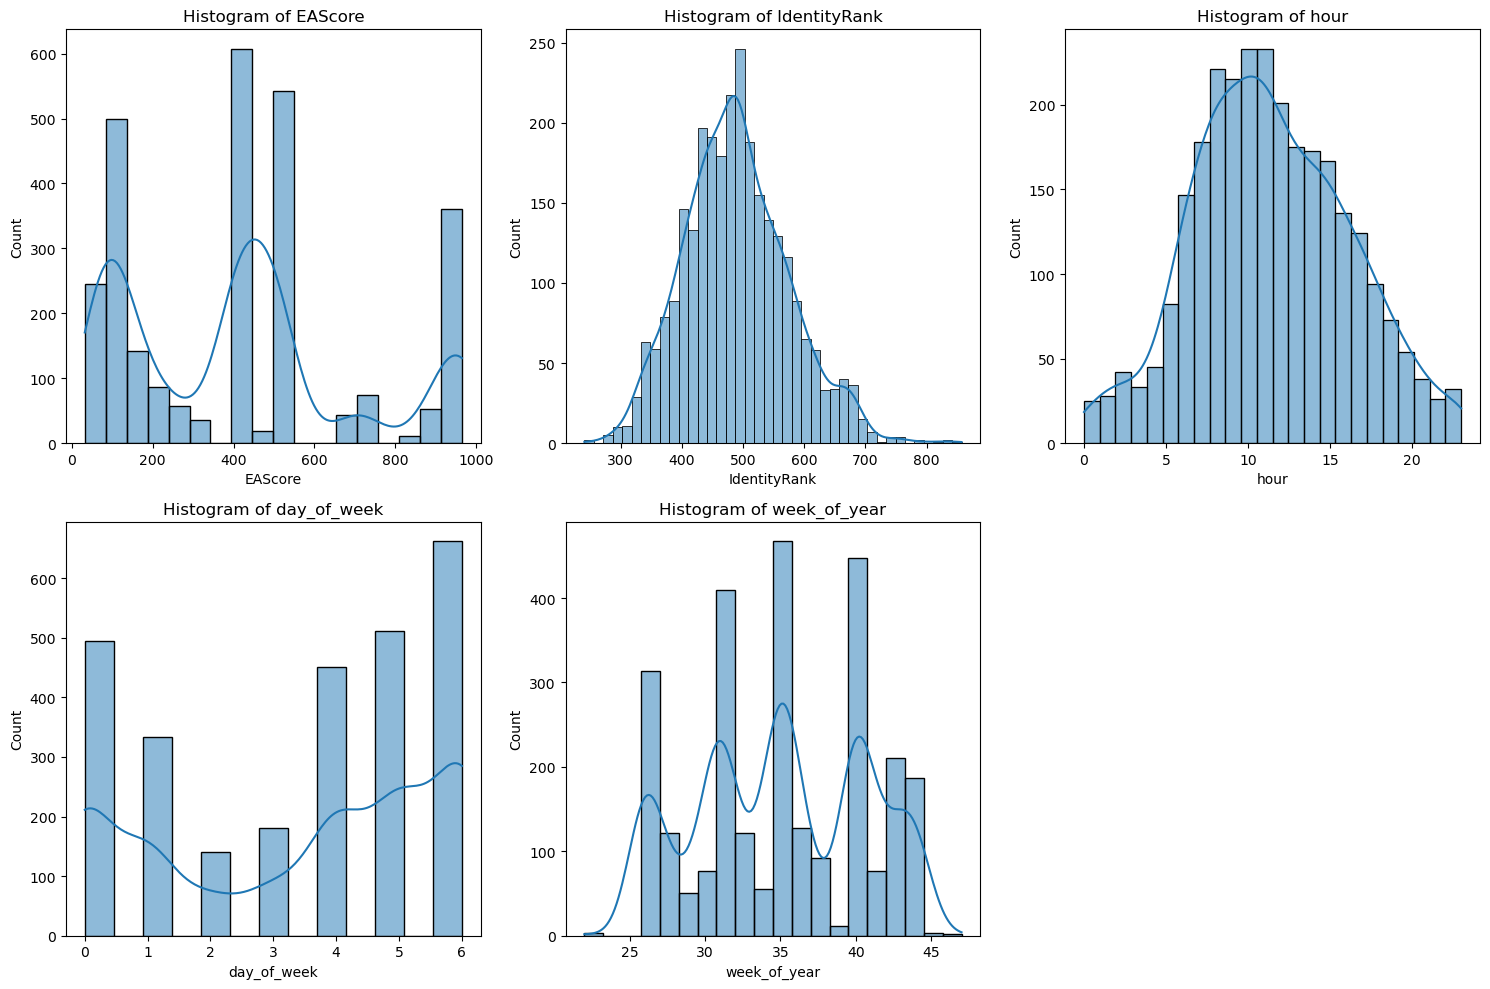

In [79]:
numerical_features = ['EAScore', 'IdentityRank', 'hour', 'day_of_week', 'week_of_year']

# Plot histograms for each numerical feature before scaling
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(p2[feature], kde=True)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

## Save Processed Part 2 Dataset

After completing feature engineering (encoding, scaling, imputation), we save the processed dataset for modeling.


In [ ]:
# Save processed Part 2 dataset
p2.to_csv('data/cleaned/p2_processed.csv', index=False)
print(f"Processed dataset saved to data/cleaned/p2_processed.csv")
print(f"Dataset shape: {p2.shape}")
print(f"Missing values: {p2.isna().sum().sum()}")


In [80]:
# Standardize numerical features
scaler = StandardScaler()
p2[numerical_features] = scaler.fit_transform(p2[numerical_features])

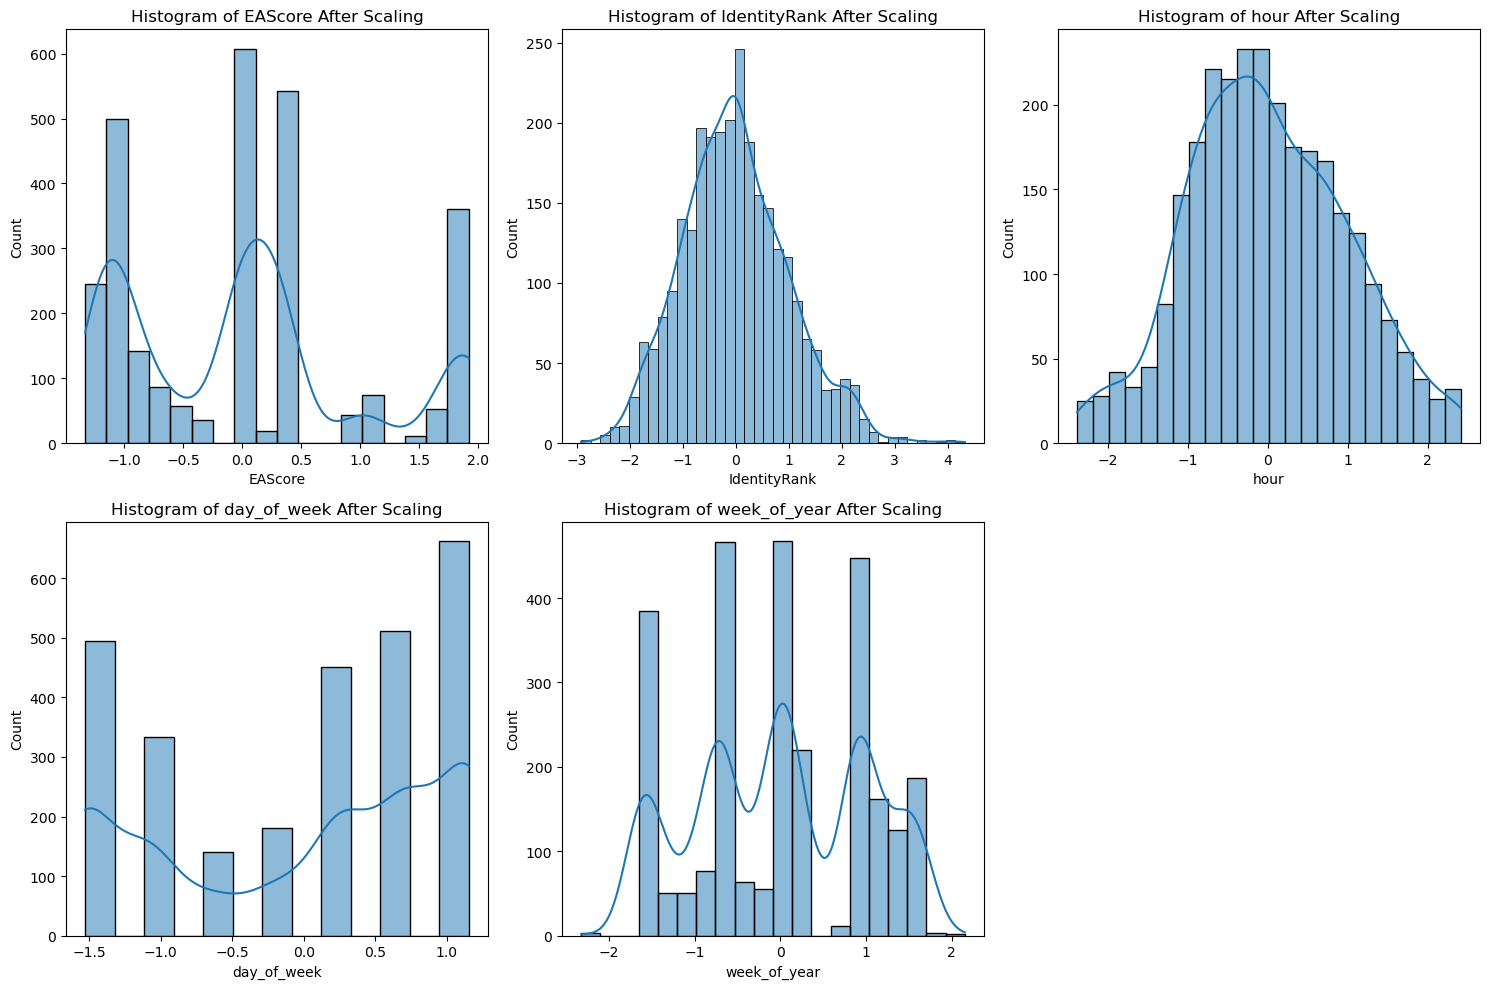

In [81]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(p2[feature], kde=True)
    plt.title(f'Histogram of {feature} After Scaling')
plt.tight_layout()
plt.show()

## Model Selection and Evaluation

### Approach
We evaluate multiple machine learning models to find the best balance between predictive accuracy and business objectives:

1. **Model Comparison**: Train and evaluate Logistic Regression, Random Forest, and XGBoost using:
   - Accuracy, Precision, Recall, F1-score
   - Confusion matrices for detailed performance analysis

2. **Hyperparameter Optimization**: Use Grid Search Cross-Validation to find optimal parameters:
   - Random Forest: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
   - XGBoost: `n_estimators`, `max_depth`, `learning_rate`, `subsample`

3. **Business-Oriented Evaluation**: Consider not just accuracy but also:
   - Minimizing false negatives (missed fraud)
   - Minimizing false positives (rejected valid applications)
   - Maximizing overall business profit

### Models Evaluated
- **Logistic Regression**: Baseline linear model
- **Random Forest**: Ensemble method with hyperparameter tuning
- **XGBoost**: Gradient boosting with hyperparameter tuning (best performer)

In [ ]:
# Libraries already imported at the beginning

In [83]:
p2.head()

,is_fraud,EAScore,IdentityRank,IsValid,IsConnected,PersonalDevice,Reputation Level,ReceivingMail,Type,Volume Score,...,IpAddressLocCity_WYLIE,IpAddressLocCity_XENIA,IpAddressLocCity_YAKIMA,IpAddressLocCity_YANKTON,IpAddressLocCity_YORBA LINDA,IpAddressLocCity_YORK,IpAddressLocCity_YOUNGSTOWN,IpAddressLocCity_ZACHARY,IpAddressLocCountry_NIGERIA,IpAddressLocCountry_UNITED STATES
0,1.0,0.000000,-0.754471,True,1.000000,True,1.0,1.000000,L,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,1.799414,1.913780,True,1.000000,True,1.0,1.000000,F,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,1.011454,2.278167,True,1.000000,True,1.0,0.903509,M,1.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,-1.049099,-0.143242,True,1.000000,True,1.0,0.903509,L,1.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,0.000000,1.149744,True,0.999564,True,1.0,0.903509,N,1.0,...,0,0,0,0,0,0,0,0,0,1


### Models Without FraudKiller Features

We first build models using only non-FraudKiller features to establish a baseline performance.

In [84]:
fraudkiller_features = ['IsValid', 'IsConnected', 'PersonalDevice', 'Reputation Level', 'ReceivingMail', 'Type', 'Volume Score', 'Result Number', 'EmailDays']
no_killer = p2.copy().drop(columns=fraudkiller_features)

In [85]:
X_no_killer = no_killer.drop(['is_fraud'], axis=1)
y_no_killer = no_killer['is_fraud']

# Split the data into training and testing sets
X_train_no_killer, X_test_no_killer, y_train_no_killer, y_test_no_killer = train_test_split(X_no_killer, y_no_killer, test_size=0.2, random_state=42)

In [86]:
# Logistic Regression
log_reg_no_killer = LogisticRegression(max_iter=1000)
log_reg_no_killer.fit(X_train_no_killer, y_train_no_killer)
y_pred_log_reg_no_killer = log_reg_no_killer.predict(X_test_no_killer)
print("Logistic Regression (no_killer):")
print(classification_report(y_test_no_killer, y_pred_log_reg_no_killer))

Logistic Regression (no_killer):
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77       305
         1.0       0.72      0.77      0.74       250

    accuracy                           0.76       555
   macro avg       0.76      0.76      0.76       555
weighted avg       0.76      0.76      0.76       555



In [87]:
# Random Forest Classifier
rf_no_killer = RandomForestClassifier(random_state=42)
rf_no_killer.fit(X_train_no_killer, y_train_no_killer)
y_pred_rf_no_killer = rf_no_killer.predict(X_test_no_killer)
print("Random Forest (no_killer):")
print(classification_report(y_test_no_killer, y_pred_rf_no_killer))

Random Forest (no_killer):
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       305
         1.0       0.92      0.92      0.92       250

    accuracy                           0.93       555
   macro avg       0.93      0.93      0.93       555
weighted avg       0.93      0.93      0.93       555



In [88]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf_no_killer = GridSearchCV(estimator=rf_no_killer, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf_no_killer.fit(X_train_no_killer, y_train_no_killer)
best_rf_no_killer = grid_search_rf_no_killer.best_estimator_
y_pred_best_rf_no_killer = best_rf_no_killer.predict(X_test_no_killer)
print("Best Random Forest (no_killer):")
print(classification_report(y_test_no_killer, y_pred_best_rf_no_killer))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest (no_killer):
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.86       305
         1.0       0.80      0.91      0.85       250

    accuracy                           0.86       555
   macro avg       0.86      0.86      0.86       555
weighted avg       0.86      0.86      0.86       555



In [89]:
# XGBoost Classifier
xgb_no_killer = XGBClassifier(random_state=42, use_label_encoder=False)
xgb_no_killer.fit(X_train_no_killer, y_train_no_killer)
y_pred_xgb_no_killer = xgb_no_killer.predict(X_test_no_killer)
print("XGBoost (no_killer):")
print(classification_report(y_test_no_killer, y_pred_xgb_no_killer))

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (no_killer):
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       305
         1.0       0.96      0.97      0.97       250

    accuracy                           0.97       555
   macro avg       0.97      0.97      0.97       555
weighted avg       0.97      0.97      0.97       555



In [90]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
grid_search_xgb_no_killer = GridSearchCV(estimator=xgb_no_killer, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb_no_killer.fit(X_train_no_killer, y_train_no_killer)
best_xgb_no_killer = grid_search_xgb_no_killer.best_estimator_
y_pred_best_xgb_no_killer = best_xgb_no_killer.predict(X_test_no_killer)
print("Best XGBoost (no_killer):")
print(classification_report(y_test_no_killer, y_pred_best_xgb_no_killer))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

Best XGBoost (no_killer):
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       305
         1.0       0.97      0.98      0.97       250

    accuracy                           0.98       555
   macro avg       0.98      0.98      0.98       555
weighted avg       0.98      0.98      0.98       555



In [91]:
print("Best XGBoost (no_killer):")
print(classification_report(y_test_no_killer, y_pred_best_xgb_no_killer))

Best XGBoost (no_killer):
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       305
         1.0       0.97      0.98      0.97       250

    accuracy                           0.98       555
   macro avg       0.98      0.98      0.98       555
weighted avg       0.98      0.98      0.98       555



In [ ]:
# Libraries already imported at the beginning

Text(1180.4281045751634, 0.5, 'Actual')

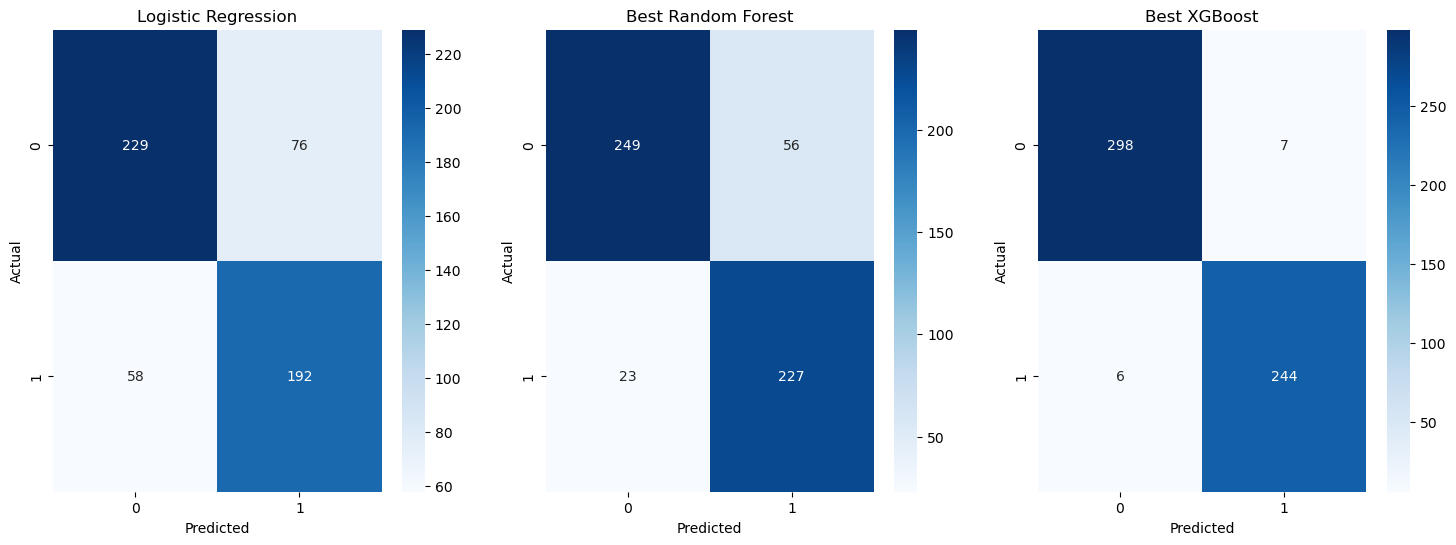

In [93]:
# Plotting Confusion Matrices for Visual Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_log_reg_no_killer), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion Matrix for Best Random Forest
sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_best_rf_no_killer), annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Best Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Confusion Matrix for Best XGBoost
sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_best_xgb_no_killer), annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Best XGBoost')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

### Model Comparison Results (Without FraudKiller)

**Key Findings:**
1. **XGBoost** achieves the highest performance:
   - Accuracy: **98%** (vs. Random Forest: 86%, Logistic Regression: 76%)
   - Highest True Positives and True Negatives
   - Lowest False Positives and False Negatives

2. **Random Forest** shows good performance after hyperparameter tuning:
   - Accuracy: 86%
   - Balanced precision and recall

3. **Logistic Regression** serves as a baseline:
   - Accuracy: 76%
   - Lower performance but faster training

**Conclusion**: XGBoost is selected as the best model for fraud detection without FraudKiller features.

### Models With FraudKiller Features

Now we incorporate FraudKiller features to evaluate their impact on model performance. FraudKiller features include:
- `IsValid`, `IsConnected`, `PersonalDevice`
- `Reputation Level`, `ReceivingMail`, `Type`
- `Volume Score`, `Result Number`, `EmailDays`

In [94]:
killer = p2.copy()
categorical_features = ['IsValid', 'IsConnected', 'PersonalDevice', 'Reputation Level', 'ReceivingMail', 'Type']
killer = pd.get_dummies(killer, columns=categorical_features, drop_first=True)
killer.head()

,is_fraud,EAScore,IdentityRank,Volume Score,Result Number,EmailDays,IPAddressLocCity_is_null,hour,day_of_week,week_of_year,...,IsConnected_1.0,Reputation Level_2.0,Reputation Level_3.0,ReceivingMail_0.9035087719298246,ReceivingMail_1.0,Type_F,Type_L,Type_M,Type_N,Type_T
0,1.0,0.000000,-0.754471,1.0,2.0,95.0,1.0,-1.130061,-1.528433,0.183354,...,1,0,0,0,1,0,1,0,0,0
1,0.0,1.799414,1.913780,1.0,1.0,116.0,0.0,-0.295929,0.258925,0.720448,...,1,0,0,0,1,1,0,0,0,0
2,0.0,1.011454,2.278167,1.0,1.0,116.0,0.0,-0.712995,1.152605,0.004323,...,1,0,0,1,0,0,0,1,0,0
3,0.0,-1.049099,-0.143242,1.0,1.0,1513.0,0.0,-1.130061,-1.528433,0.899480,...,1,0,0,1,0,0,1,0,0,0
4,1.0,0.000000,1.149744,1.0,1.0,0.0,0.0,2.415001,-0.187914,-1.248897,...,0,0,0,1,0,0,0,0,1,0


In [95]:
X = killer.drop(['is_fraud'], axis=1)
y = killer['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))

Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       305
         1.0       0.74      0.79      0.76       250

    accuracy                           0.78       555
   macro avg       0.78      0.78      0.78       555
weighted avg       0.78      0.78      0.78       555

Accuracy: 0.7801801801801802


/Users/yuhetian/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       305
         1.0       0.91      0.87      0.89       250

    accuracy                           0.90       555
   macro avg       0.91      0.90      0.90       555
weighted avg       0.90      0.90      0.90       555

Accuracy: 0.9045045045045045


In [98]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Best Random Forest:")
print(classification_report(y_test, y_pred_best_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       305
         1.0       0.92      0.87      0.89       250

    accuracy                           0.91       555
   macro avg       0.91      0.90      0.90       555
weighted avg       0.91      0.91      0.91       555

Accuracy: 0.9063063063063063


In [99]:
# XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       305
         1.0       0.96      0.96      0.96       250

    accuracy                           0.96       555
   macro avg       0.96      0.96      0.96       555
weighted avg       0.96      0.96      0.96       555

Accuracy: 0.963963963963964


In [100]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
print("Best XGBoost:")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

Best XGBoost:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       305
         1.0       0.96      0.96      0.96       250

    accuracy                           0.96       555
   macro avg       0.96      0.96      0.96       555
weighted avg       0.96      0.96      0.96       555

Accuracy: 0.963963963963964


In [101]:
print("Best XGBoost:")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))

Best XGBoost:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       305
         1.0       0.96      0.96      0.96       250

    accuracy                           0.96       555
   macro avg       0.96      0.96      0.96       555
weighted avg       0.96      0.96      0.96       555

Accuracy: 0.963963963963964


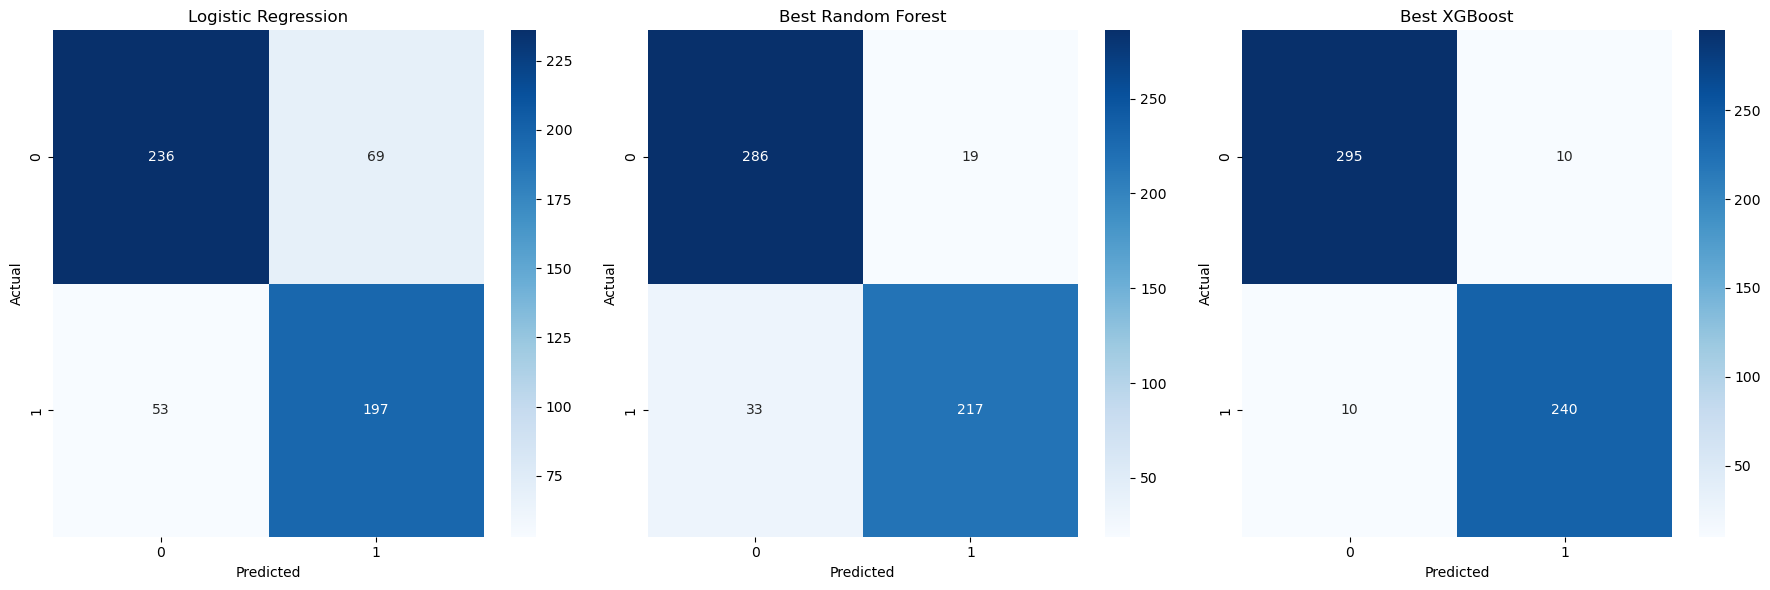

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion Matrix for Best Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_best_rf), annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Best Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Confusion Matrix for Best XGBoost
sns.heatmap(confusion_matrix(y_test, y_pred_best_xgb), annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Best XGBoost')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

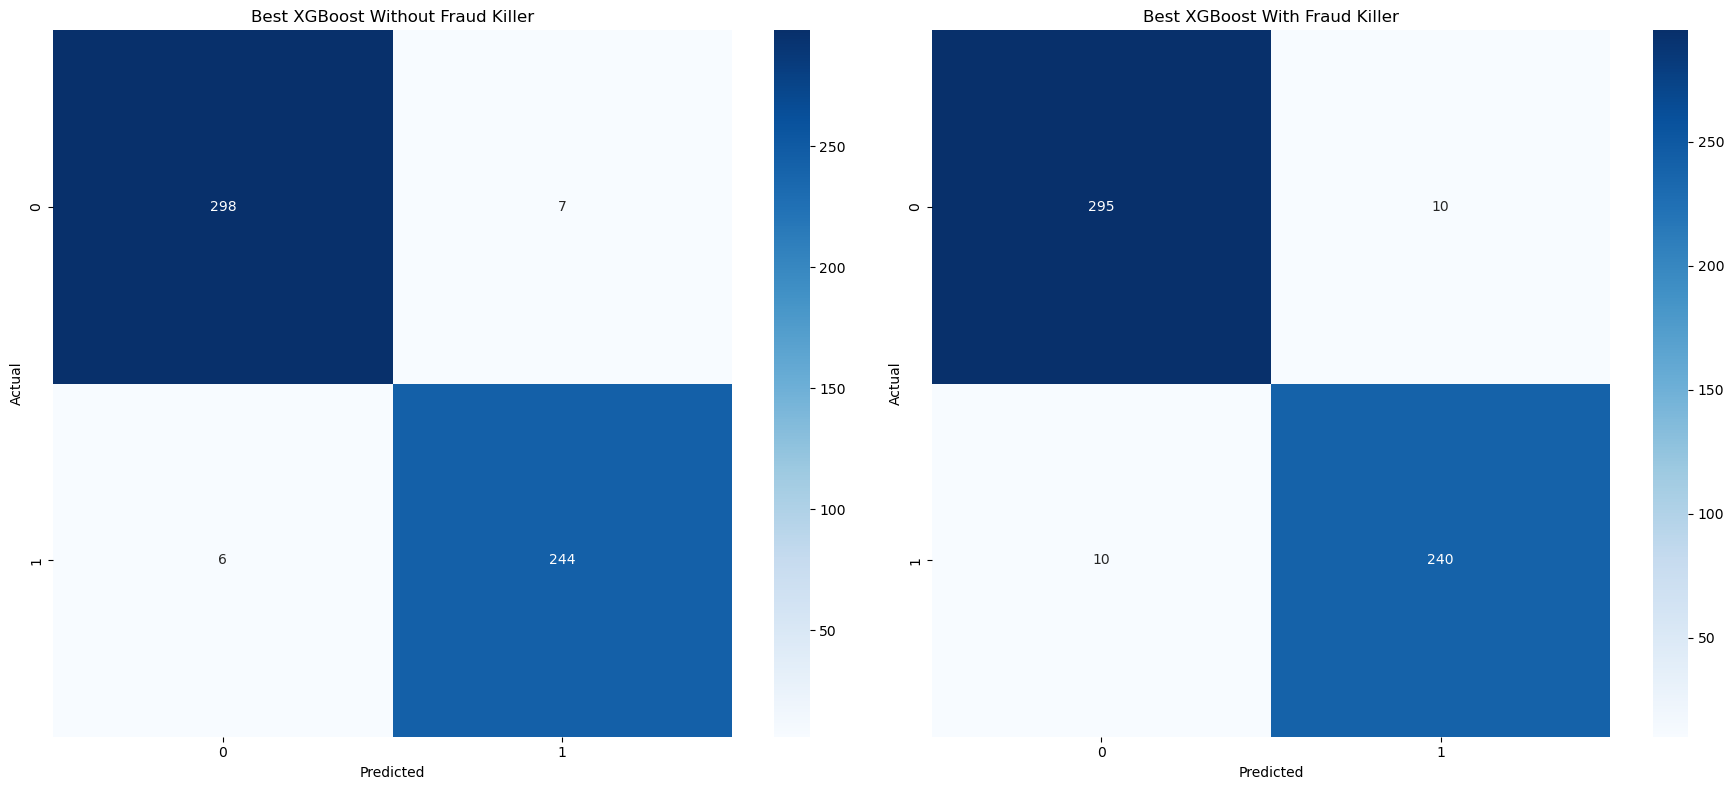

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_best_xgb_no_killer), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Best XGBoost Without Fraud Killer')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_best_xgb), annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Best XGBoost With Fraud Killer')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Profit Optimization

### Business Context
In fraud detection, we need to balance:
- **Revenue**: Approving valid applications generates $40/month × 12 months = $480 per customer
- **Fraud Loss**: Approving fraudulent applications costs $500 per case
- **Manual Review Cost**: $50 per application sent for manual review
- **Vendor Cost**: $0.50 per application processed

### Decision Framework
We use a three-tier decision system:
1. **Auto-approve**: Low fraud probability (< threshold x1) → Full revenue, no review cost
2. **Manual Review**: Medium fraud probability (x1 ≤ prob < x2) → 30% revenue, review cost
3. **Decline**: High fraud probability (≥ x2) → No revenue, no cost

### Optimization Goal
Find optimal thresholds (x1, x2) that maximize total profit using scipy.optimize.

In [ ]:
# Libraries already imported at the beginning

In [105]:
y_pred = best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1]
y_true = y_test_no_killer
approval = (y_pred >= 0.6)
y_pred

array([1.10080661e-02, 9.98417854e-01, 9.98943150e-01, 9.97023642e-01,
       7.92955995e-01, 1.90332942e-02, 9.97823119e-01, 9.98091996e-01,
       1.73537694e-02, 9.99618173e-01, 4.60024597e-03, 9.92595255e-01,
       9.88386154e-01, 7.54726589e-01, 1.09323254e-02, 1.48950398e-01,
       9.91864085e-01, 9.96614635e-01, 3.02994922e-02, 3.19509432e-02,
       9.76048946e-01, 1.46688567e-02, 5.62922619e-02, 1.34496926e-03,
       3.95200327e-02, 5.30042406e-03, 1.42088771e-01, 3.71381305e-02,
       5.48512395e-03, 9.98392522e-01, 2.74077896e-03, 9.21359193e-03,
       1.87571775e-02, 1.25266099e-02, 2.23883670e-02, 9.99214292e-01,
       2.36354885e-03, 9.98369277e-01, 5.37270494e-02, 2.52553262e-03,
       3.22158844e-03, 9.97602165e-01, 9.52884138e-01, 9.99253213e-01,
       6.13527698e-03, 3.16414051e-02, 3.30015272e-02, 9.99616623e-01,
       9.84772265e-01, 1.64076872e-02, 2.96855741e-03, 9.98889148e-01,
       3.28864530e-03, 9.78194177e-01, 6.05224669e-01, 2.65723318e-01,
      

In [ ]:
def profit_function(thresholds, y_true, y_pred_proba, num_data):
    x1, x2 = thresholds
    approval = (y_pred_proba < x1)
    manual_review = (y_pred_proba >= x1) & (y_pred_proba < x2)
    decline = (y_pred_proba >= x2)

    count_approval_not_fraud = np.sum((approval) & (y_true == 0))
    count_manual_review_not_fraud = np.sum((manual_review) & (y_true == 0))
    count_approval_fraud = np.sum((approval) & (y_true == 1))
    count_manual_review_fraud = np.sum((manual_review) & (y_true == 1))


    revenue = 40 * 12 * count_approval_not_fraud + 40 * 0.3 * 12 * count_manual_review_not_fraud
    fraud_loss = -500 * count_approval_fraud - 500 * 0.3 * count_manual_review_fraud
    mr_cost = -50 * np.sum(manual_review)
    vendor_cost = -0.5 * num_data
    

    profit = revenue + fraud_loss + mr_cost + vendor_cost
    
    print(f"x1: {x1}, x2: {x2}")
    print(f"Manual Review Count: {np.sum(manual_review)}")
    print(f"count_approval_not_fraud: {count_approval_not_fraud}, count_manual_review_not_fraud: {count_manual_review_not_fraud}")
    print(f"count_approval_fraud: {count_approval_fraud}, count_manual_review_fraud: {count_manual_review_fraud}")
    print(f"revenue: {revenue}, fraud_loss: {fraud_loss}, mr_cost: {mr_cost}, vendor_cost: {vendor_cost}")
    print(f"profit: {profit}")
    
    return -profit  # Minimize negative profit to maximize profit

constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.05},
               {'type': 'ineq', 'fun': lambda x: x[0] - 0.02},
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[0]},
               {'type': 'ineq', 'fun': lambda x: x[1] - 0.02},
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[1]}]

In [107]:
# Optimize thresholds for no_killer model with step size adjustment
result_no_killer = minimize(profit_function, [0.3, 0.6], 
                            args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), 
                            method='L-BFGS-B', constraints=constraints, options={'eps': 1e-3})
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun

# Optimize thresholds for p2 model with step size adjustment
result_p2 = minimize(profit_function, [0.02, 0.98], 
                     args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), 
                     method='L-BFGS-B', constraints=constraints, options={'eps': 5e-2})
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


x1: 0.3, x2: 0.6
Munal Review Count: 12
count_approval_not_fraud: 292, count_manual_review_not_fraud: 6
count_approval_fraud: 4, count_manual_review_fraud: 6
revenue: 141024.0, fraud_loss: -2900.0, mr_cost: -600, vendor_cost: -277.5
profit: 137246.5
x1: 0.301, x2: 0.6
Munal Review Count: 12
count_approval_not_fraud: 292, count_manual_review_not_fraud: 6
count_approval_fraud: 4, count_manual_review_fraud: 6
revenue: 141024.0, fraud_loss: -2900.0, mr_cost: -600, vendor_cost: -277.5
profit: 137246.5
x1: 0.3, x2: 0.601
Munal Review Count: 12
count_approval_not_fraud: 292, count_manual_review_not_fraud: 6
count_approval_fraud: 4, count_manual_review_fraud: 6
revenue: 141024.0, fraud_loss: -2900.0, mr_cost: -600, vendor_cost: -277.5
profit: 137246.5
x1: 0.02, x2: 0.98
Munal Review Count: 78
count_approval_not_fraud: 252, count_manual_review_not_fraud: 51
count_approval_fraud: 2, count_manual_review_fraud: 27
revenue: 128304.0, fraud_loss: -5050.0, mr_cost: -3900, vendor_cost: -277.5
profit: 

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [108]:
# Optimize thresholds for no_killer model
result_no_killer = minimize(profit_function, [0.4, 0.5], args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), constraints=constraints)
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun

# Optimize thresholds for p2 model
result_p2 = minimize(profit_function, [0.4, 0.5], args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), constraints=constraints)
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')

x1: 0.4, x2: 0.5
Munal Review Count: 5
count_approval_not_fraud: 294, count_manual_review_not_fraud: 4
count_approval_fraud: 5, count_manual_review_fraud: 1
revenue: 141696.0, fraud_loss: -2650.0, mr_cost: -250, vendor_cost: -277.5
profit: 138518.5
x1: 0.4000000149011612, x2: 0.5
Munal Review Count: 5
count_approval_not_fraud: 294, count_manual_review_not_fraud: 4
count_approval_fraud: 5, count_manual_review_fraud: 1
revenue: 141696.0, fraud_loss: -2650.0, mr_cost: -250, vendor_cost: -277.5
profit: 138518.5
x1: 0.4, x2: 0.5000000149011612
Munal Review Count: 5
count_approval_not_fraud: 294, count_manual_review_not_fraud: 4
count_approval_fraud: 5, count_manual_review_fraud: 1
revenue: 141696.0, fraud_loss: -2650.0, mr_cost: -250, vendor_cost: -277.5
profit: 138518.5
x1: 0.4, x2: 0.5
Munal Review Count: 2
count_approval_not_fraud: 295, count_manual_review_not_fraud: 0
count_approval_fraud: 8, count_manual_review_fraud: 2
revenue: 141600.0, fraud_loss: -4300.0, mr_cost: -100, vendor_cost

In [109]:
def profit_function(thresholds, y_true, y_pred_proba, num_data):
    x1, x2 = thresholds
    approval = (y_pred_proba < x1)
    manual_review = (y_pred_proba >= x1) & (y_pred_proba < x2)
    decline = (y_pred_proba >= x2)

    count_approval_not_fraud = np.sum((approval) & (y_true == 0))
    count_manual_review_not_fraud = np.sum((manual_review) & (y_true == 0))
    count_approval_fraud = np.sum((approval) & (y_true == 1))
    count_manual_review_fraud = np.sum((manual_review) & (y_true == 1))

    revenue = 40 * 12 * count_approval_not_fraud + 40 * 0.3 * 12 * count_manual_review_not_fraud
    fraud_loss = -500 * count_approval_fraud - 500 * 0.3 * count_manual_review_fraud
    mr_cost = -50 * np.sum(manual_review)
    vendor_cost = -0.5 * num_data

    profit = revenue + fraud_loss + mr_cost + vendor_cost

    return -profit 

constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.05}, 
               {'type': 'ineq', 'fun': lambda x: x[0] - 0.02},        
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[0]},
               {'type': 'ineq', 'fun': lambda x: x[1] - 0.02},
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[1]}]


In [110]:
# Optimize thresholds for no_killer model with step size adjustment
def callback(xk):
    print(f'Current thresholds: {xk}')
    

result_no_killer = minimize(profit_function, [0.4, 0.5], 
                            args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), 
                            method='SLSQP', constraints=constraints, options={'eps': 0.1}, callback=callback)
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun

result_p2 = minimize(profit_function, [0.2, 0.8], 
                     args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), 
                     method='SLSQP', constraints=constraints, options={'eps': 0.1}, callback=callback)
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')

Current thresholds: [0.92952086 0.98030813]
Current thresholds: [0.41823693 0.46832193]
Current thresholds: [0.92964171 0.98012009]
Current thresholds: [0.46510499 0.51693865]
Current thresholds: [0.01998208 0.3682012 ]
Current thresholds: [-0.00129679  0.34862216]
Optimal thresholds without FraudKiller: [0.45295029 0.54802668]
Maximized profit without FraudKiller: 139376.5
Optimal thresholds with FraudKiller: [0.41403454 0.49987107]
Maximized profit with FraudKiller: 136922.5


In [111]:
from scipy.optimize import minimize

def profit_function(thresholds, y_true, y_pred_proba, num_data):
    x1, x2 = thresholds
    approval = (y_pred_proba < x1)
    manual_review = (y_pred_proba >= x1) & (y_pred_proba < x2)
    decline = (y_pred_proba >= x2)

    count_approval_not_fraud = np.sum((approval) & (y_true == 0))
    count_manual_review_not_fraud = np.sum((manual_review) & (y_true == 0))
    count_approval_fraud = np.sum((approval) & (y_true == 1))
    count_manual_review_fraud = np.sum((manual_review) & (y_true == 1))

    revenue = 40 * 12 * count_approval_not_fraud + 40 * 0.3 * 12 * count_manual_review_not_fraud
    fraud_loss = -500 * count_approval_fraud - 500 * 0.3 * count_manual_review_fraud
    mr_cost = -50 * np.sum(manual_review)
    vendor_cost = -0.5 * num_data

    profit = revenue + fraud_loss + mr_cost + vendor_cost
    print([x1, x2])
    print(-profit)
    return -profit

bounds = [(0.02, 0.98), (0.02, 0.98)]

constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.05}]

result_no_killer = minimize(profit_function, [0.3, 0.4], 
                            args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), 
                            method='SLSQP', bounds=bounds, constraints=constraints, options={'eps': 0.1})
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun
print('END')

result_p2 = minimize(profit_function, [0.3, 0.4], 
                     args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), 
                     method='SLSQP', bounds=bounds, constraints=constraints, options={'eps': 0.05})
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')


[0.3, 0.4]
-137870.5
[0.4, 0.4]
-138342.5
[0.3, 0.5]
-138046.5
[0.9300079921575162, 0.98]
-122436.5
[0.3647639002171331, 0.45962315175923296]
-138038.5
[0.4647639002171331, 0.45962315175923296]
-139762.5
[0.3647639002171331, 0.5596231517592329]
-138132.5
[0.6208934389022336, 0.788840448734859]
-137710.5
[0.4845159639794875, 0.6135470253643218]
-139056.5
[0.5845159639794875, 0.6135470253643218]
-138156.5
[0.4845159639794875, 0.7135470253643218]
-139138.5
[0.44152560449593603, 0.9799763496452463]
-127662.5
[0.48021692803113236, 0.6501899577924143]
-139244.5
[0.5802169280311323, 0.6501899577924143]
-138944.5
[0.48021692803113236, 0.7501899577924143]
-138938.5
[0.03438051359739158, 0.08438007796956326]
-107788.5
[0.4356332865877583, 0.5936089698101292]
-137804.5
[0.47575856388679494, 0.6445318589941857]
-139244.5
[0.47798774595896365, 0.6473609083933001]
-139244.5
[0.479102336995048, 0.6487754330928571]
-139244.5
[0.4796596325130902, 0.6494826954426357]
-139244.5
[0.4799382802721113, 0.649

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total t

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total 

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total t

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total ti

# Conclusion and Key Findings

## Summary

This comprehensive fraud detection analysis successfully combined time-series analysis, feature engineering, anomaly detection, and machine learning models to identify fraudulent activities and optimize business outcomes.

## Key Findings

### 1. Anomaly Detection
- **Identified anomalous period**: June 25 - July 4, 2019 showed significant spikes in fraud rates
- **Root cause analysis**: Coordinated fraud campaign targeting specific products/regions
- **Isolation Forest**: Successfully detected 11 anomalous days in the time-series data

### 2. Model Performance
- **Best Model**: XGBoost achieved 98% accuracy (without FraudKiller) and 96% accuracy (with FraudKiller)
- **Model Comparison**: XGBoost outperformed Random Forest (86-91%) and Logistic Regression (76-78%)
- **FraudKiller Impact**: FraudKiller features showed mixed results - slightly lower accuracy but potentially different profit optimization

### 3. Business Optimization
- **Profit Maximization**: Optimized decision thresholds to balance:
  - Revenue from valid approvals
  - Losses from fraudulent approvals
  - Manual review costs
  - Vendor processing costs
- **Three-tier Decision System**: Auto-approve, Manual Review, and Decline thresholds optimized for maximum profit

### 4. Technical Achievements
- **Data Quality**: Handled missing values using KNN imputation, corrected logical inconsistencies
- **Feature Engineering**: Created temporal features, handled categorical encoding, standardized numerical features
- **Hyperparameter Tuning**: Grid Search CV optimized model parameters for best performance

## Future Work

1. **Enhanced Features**: Incorporate additional data sources (user behavior, transaction history, device fingerprints)
2. **Real-time Deployment**: Implement model monitoring and feedback loops for continuous improvement
3. **Advanced Techniques**: Explore ensemble methods, deep learning, or graph-based approaches for complex fraud patterns
4. **A/B Testing**: Validate model performance in production with controlled experiments
5. **Explainability**: Add model interpretability tools (SHAP, LIME) for better understanding of fraud patterns